In [1]:
import xarray as xa
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy
import copy
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr

/global/homes/d/duan0000/.conda/envs/duan/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
file = 'NAM_precip_records_Baja'
data = xa.open_dataset(file)
print(data)

<xarray.Dataset>
Dimensions:  (time: 14975, nam_ind: 487)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * nam_ind  (nam_ind) int64 3589 3592 3593 3737 3738 ... 8475 8476 8622 8623
Data variables:
    precip   (nam_ind, time) float32 ...
    lat      (nam_ind) float32 ...
    lon      (nam_ind) float32 ...


In [3]:
summer_data = data.sel(time=data.time.dt.month.isin([6,7,8,9]))
print(summer_data)

<xarray.Dataset>
Dimensions:  (time: 5002, nam_ind: 487)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2019-09-30
  * nam_ind  (nam_ind) int64 3589 3592 3593 3737 3738 ... 8475 8476 8622 8623
Data variables:
    precip   (nam_ind, time) float32 ...
    lat      (nam_ind) float32 ...
    lon      (nam_ind) float32 ...


(5002,)
<xarray.DataArray 'month_day' (time: 5002)>
array(['06-01', '06-02', '06-03', ..., '09-28', '09-29', '09-30'], dtype=object)
Coordinates:
  * time     (time) object '06-01' '06-02' '06-03' ... '09-28' '09-29' '09-30'
<xarray.Dataset>
Dimensions:    (month_day: 122, nam_ind: 487)
Coordinates:
  * nam_ind    (nam_ind) int64 3589 3592 3593 3737 3738 ... 8475 8476 8622 8623
  * month_day  (month_day) object '06-01' '06-02' '06-03' ... '09-29' '09-30'
Data variables:
    precip     (month_day, nam_ind) float32 0.6323 0.5006 0.6874 ... 1.155 1.537
    lat        (month_day, nam_ind) float32 39.75 39.75 39.75 ... 22.75 22.75
    lon        (month_day, nam_ind) float32 249.2 250.8 251.2 ... 249.8 250.2


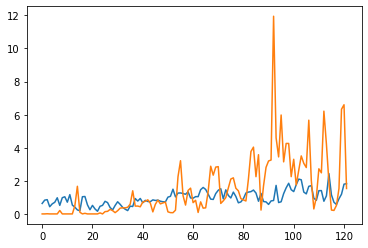

In [4]:
print(summer_data.indexes['time'].strftime('%m-%d').shape)
month_day = xa.DataArray(summer_data.indexes['time'].strftime('%m-%d'), dims={'time':summer_data.coords['time']},
                         name='month_day')
print(month_day)
summer_ltdm = summer_data.groupby(month_day).mean()
print(summer_ltdm)
plt.plot(summer_ltdm.precip.data[:,0])
plt.plot(summer_ltdm.precip.data[:,-1])
plt.show()

In [5]:
def plot_results(reverse, total):
    fig = plt.figure(figsize=(13,8))
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.coastlines(alpha=0.2)
    ax.add_feature(cartopy.feature.BORDERS, alpha=0.1)
    ax.add_feature(cartopy.feature.STATES, alpha=0.1)
    xx, yy = np.meshgrid(lon, lat)
    masked_reverse = np.ma.array(reverse, mask=reverse<0)
    palette = copy.copy(mpl.cm.get_cmap("tab20", total))
    palette.set_bad('b', 0)
    scat = ax.scatter(xx, yy, c=masked_reverse.reshape(80, 148), cmap=plt.cm.get_cmap('tab20', total), 
                     vmin=0.5, vmax=total+0.5, transform=ccrs.PlateCarree())
    ax.set_extent([240, 260, 21, 41], crs=ccrs.PlateCarree())
    divider = make_axes_locatable(ax)
    cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
    fig.add_axes(cax1)
    fig.colorbar(scat, cax=cax1, orientation='vertical', ticks=np.arange(0, total+1))
    plt.show()
def plot_signal(rank, total):
    for i in range(1, total+1):
        ind = np.where(bmu==i)
        signal = np.mean(rank[ind], axis=0)
        plt.plot(signal, label=str(i))
    plt.legend()
    plt.show()

In [6]:
nam_ind = data.nam_ind.data
# print(nam_ind)
lat = np.load('nc-data/lat_int.npy')
lon = np.load('nc-data/lon_int.npy')

In [7]:
summer_cbrt = summer_data.apply(np.cbrt)
summer_cbrt_ltdm = summer_cbrt.groupby(month_day).mean()
precip = summer_cbrt_ltdm.precip.data
precip = np.transpose(precip)
xmin = np.min(precip, axis=1)
xmax = np.max(precip, axis=1)
print(xmin.shape)
rank_proper = precip.copy()
for i in range(rank_proper.shape[0]):
    rank_proper[i] = (rank_proper[i]-xmin[i])/(xmax[i]-xmin[i]) # rank to [0,1]

print(np.nanmin(rank_proper), ' ', np.nanmax(rank_proper))
print(rank_proper.shape)
print(np.min(rank_proper[0]), ' ', np.max(rank_proper[0]), ' ', np.min(rank_proper[-1]), ' ', np.max(rank_proper[-1]))
# np.savetxt('NAM_inner_rank_proper.csv', rank_proper, delimiter=',')

(487,)
0.0   1.0
(487, 122)
0.0   1.0   0.0   1.0


(487, 2)
(array([1., 2.]), array([ 96, 391]))
2
487
(array([-1.,  1.,  2.]), array([11353,    96,   391]))
rs_max:  0.8125512739617923


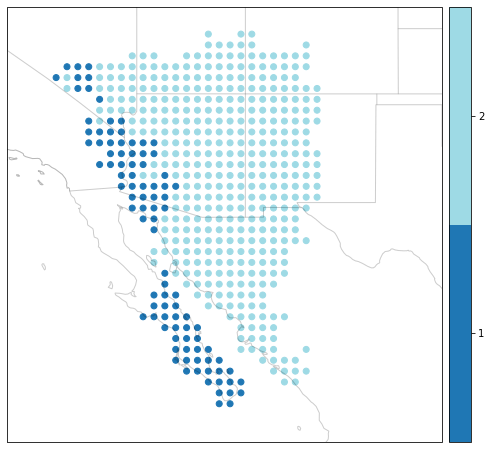

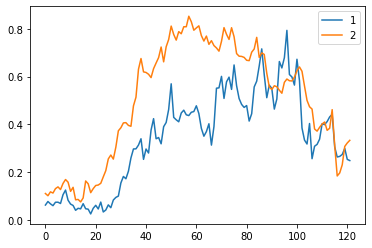

In [8]:
space = np.genfromtxt('NAM_inner_2_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 2
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_2 = []
r_all_2 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_2.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_2.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_2 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_2.append(r)
print('rs_max: ', np.max(rs_2))
plot_results(reverse, 2)
plot_signal(rank_proper, 2)

In [9]:
print(np.mean(dis_all_2))

1.3393629


(487, 2)
(array([1., 2., 3.]), array([ 84, 223, 180]))
3
487
(array([-1.,  1.,  2.,  3.]), array([11353,    84,   223,   180]))
rs_max:  0.9240030988538129


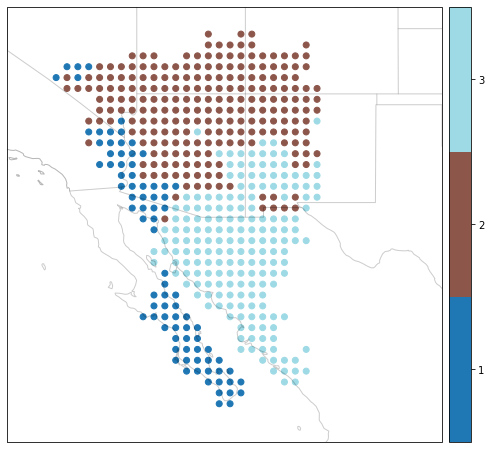

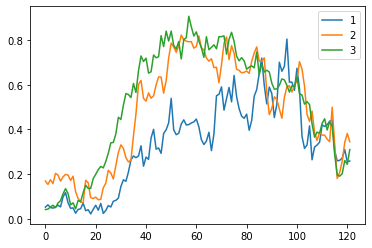

1.2384868


In [10]:
space = np.genfromtxt('NAM_inner_3_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 3
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_3 = []
r_all_3 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_3.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_3.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_3 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_3.append(r)
print('rs_max: ', np.max(rs_3))
plot_results(reverse, 3)
plot_signal(rank_proper, 3)
print(np.mean(dis_all_3))

(487, 2)
(array([1., 2., 3., 4.]), array([ 42, 108, 215, 122]))
4
487
(array([-1.,  1.,  2.,  3.,  4.]), array([11353,    42,   108,   215,   122]))
rs_max:  0.924537753078134


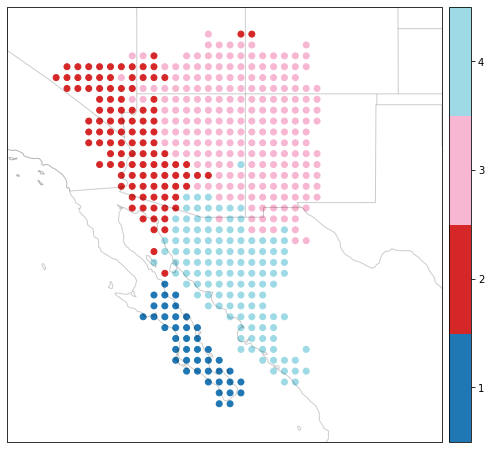

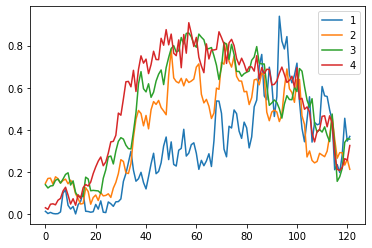

1.1410917


In [11]:
space = np.genfromtxt('NAM_inner_4_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 4
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_4 = []
r_all_4 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_4.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_4.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_4 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_4.append(r)
print('rs_max: ', np.max(rs_4))
plot_results(reverse, 4)
plot_signal(rank_proper, 4)
print(np.mean(dis_all_4))

(487, 2)
(array([1., 2., 3., 4., 5.]), array([ 42,  82, 113, 158,  92]))
5
487
(array([-1.,  1.,  2.,  3.,  4.,  5.]), array([11353,    42,    82,   113,   158,    92]))
rs_max:  0.9367126665832873


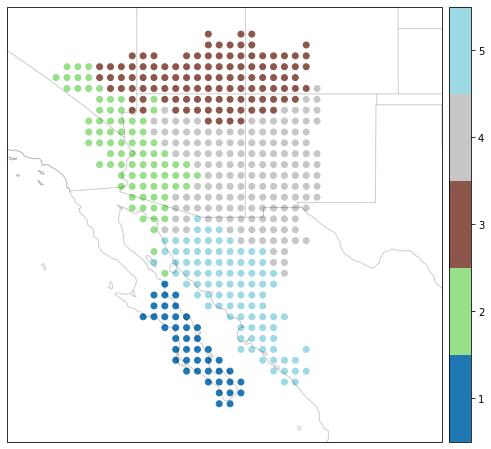

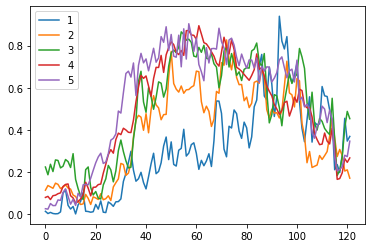

1.0794201


In [12]:
space = np.genfromtxt('NAM_inner_5_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 5
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_5 = []
r_all_5 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_5.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_5.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_5 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_5.append(r)
print('rs_max: ', np.max(rs_5))
plot_results(reverse, 5)
plot_signal(rank_proper, 5)
print(np.mean(dis_all_5))

(487, 2)
(array([1., 2., 3., 4., 5., 6.]), array([ 42,  66,  39, 107, 140,  93]))
6
487
(array([-1.,  1.,  2.,  3.,  4.,  5.,  6.]), array([11353,    42,    66,    39,   107,   140,    93]))
rs_max:  0.937364731682034


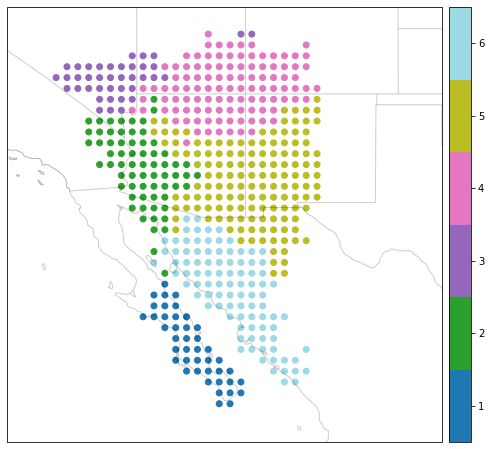

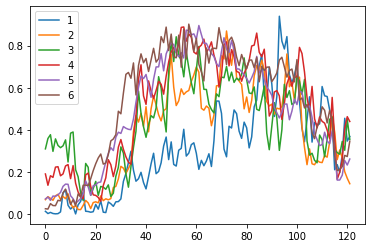

1.0410484


In [13]:
space = np.genfromtxt('NAM_inner_6_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 6
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_6 = []
r_all_6 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_6.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_6.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_6 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_6.append(r)
print('rs_max: ', np.max(rs_6))
plot_results(reverse, 6)
plot_signal(rank_proper, 6)
print(np.mean(dis_all_6))

(487, 2)
(array([1., 2., 3., 4., 5., 6., 7.]), array([ 42,  63,  40,  87, 142,  73,  40]))
7
487
(array([-1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]), array([11353,    42,    63,    40,    87,   142,    73,    40]))
rs_max:  0.9512634982437326


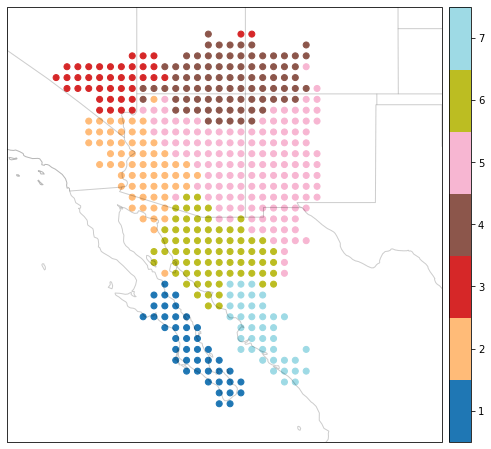

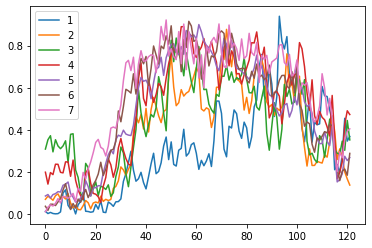

1.0129389


In [14]:
space = np.genfromtxt('NAM_inner_7_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 7
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_7 = []
r_all_7 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_7.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_7.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_7 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_7.append(r)
print('rs_max: ', np.max(rs_7))
plot_results(reverse, 7)
plot_signal(rank_proper, 7)
print(np.mean(dis_all_7))

(487, 2)
(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([42, 57, 39, 70, 84, 89, 66, 40]))
8
487
(array([-1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]), array([11353,    42,    57,    39,    70,    84,    89,    66,    40]))
rs_max:  0.9526127865624607


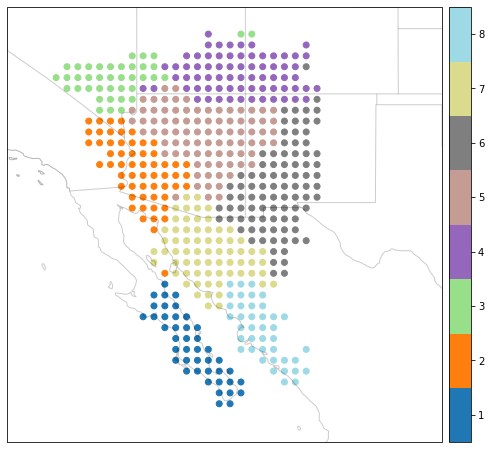

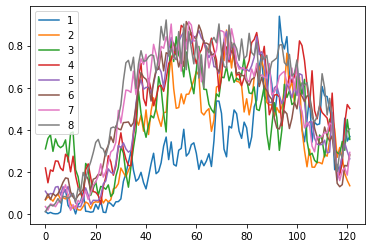

0.9811539


In [15]:
space = np.genfromtxt('NAM_inner_8_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 8
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_8 = []
r_all_8 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_8.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_8.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_8 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_8.append(r)
print('rs_max: ', np.max(rs_8))
plot_results(reverse, 8)
plot_signal(rank_proper, 8)
print(np.mean(dis_all_8))

(487, 2)
(array([1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([42, 40, 49, 39, 69, 71, 70, 63, 44]))
9
487
(array([-1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]), array([11353,    42,    40,    49,    39,    69,    71,    70,    63,
          44]))
rs_max:  0.9630704563702748


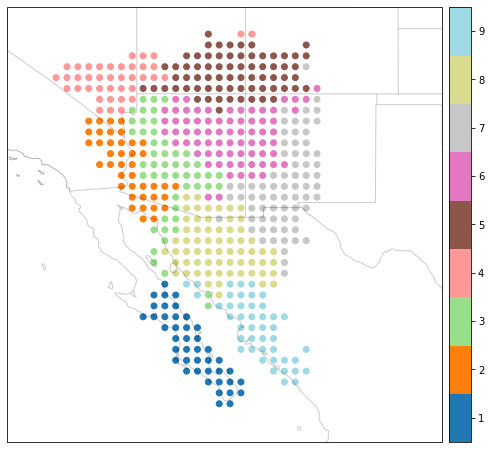

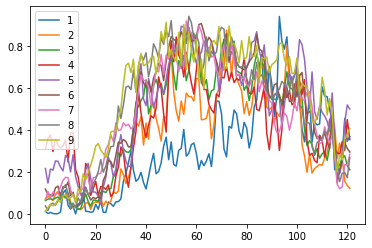

0.96196693


In [16]:
space = np.genfromtxt('NAM_inner_9_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 9
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_9 = []
r_all_9 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_9.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_9.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_9 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_9.append(r)
print('rs_max: ', np.max(rs_9))
plot_results(reverse, 9)
plot_signal(rank_proper, 9)
print(np.mean(dis_all_9))

(487, 2)
(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([42, 40, 49, 39, 46, 57, 59, 65, 60, 30]))
10
487
(array([-1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([11353,    42,    40,    49,    39,    46,    57,    59,    65,
          60,    30]))
rs_max:  0.9680871510335213


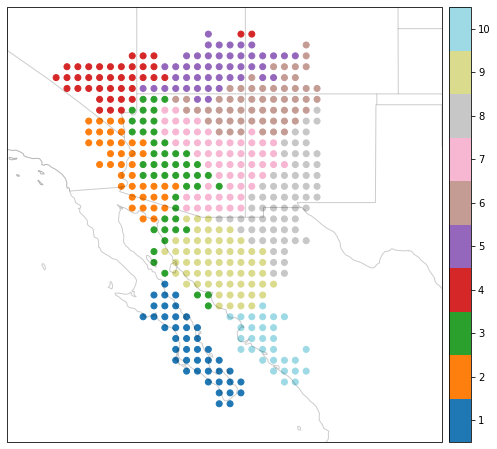

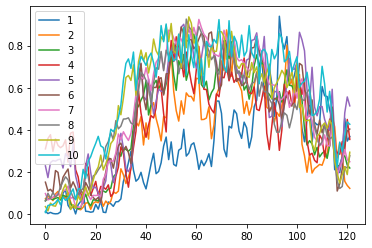

0.9438978


In [17]:
space = np.genfromtxt('NAM_inner_10_proper.txt', delimiter=',')
print(space.shape)
bmu = space[:,0]
print(np.unique(bmu, return_counts=True))
reverse = np.zeros(11840)-1
count = 0
# Get mean signal:
signals = []
total = 10
for i in range(1, total+1):
    ind = np.where(bmu==i)
    signal = np.mean(rank_proper[ind], axis=0)
    signals.append(signal)
print(len(signals))
dis_all_10 = []
r_all_10 = []
for i in range(11840):
    if i in nam_ind:
        reverse[i] = bmu[count]
        center = signals[int(bmu[count]-1)]
        dis = np.sqrt(np.sum(np.square(center-rank_proper[count])))
        dis_all_10.append(dis)
        r, p = pearsonr(center, rank_proper[count])
        r_all_10.append(r)
        count+=1
print(count)
print(np.unique(reverse, return_counts=True))
rs_10 = []
for i in range(len(signals)-1):
    for j in range(i+1, len(signals)):
        r, p = pearsonr(signals[i], signals[j])
        rs_10.append(r)
print('rs_max: ', np.max(rs_10))
plot_results(reverse, 10)
plot_signal(rank_proper, 10)
print(np.mean(dis_all_10))

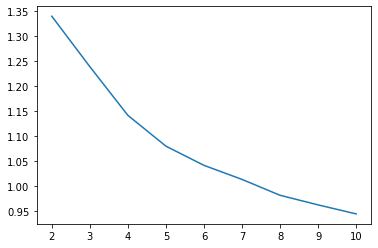

In [18]:
dis_all = [np.mean(dis_all_2), np.mean(dis_all_3), np.mean(dis_all_4), 
           np.mean(dis_all_5), np.mean(dis_all_6), np.mean(dis_all_7),
           np.mean(dis_all_8), np.mean(dis_all_9), np.mean(dis_all_10)]
plt.plot(dis_all)
plt.xticks(np.arange(9), np.arange(2, 11))
plt.show()

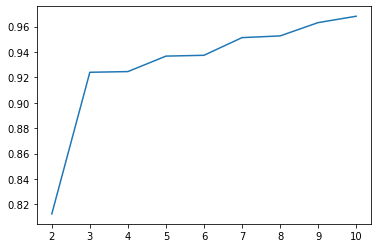

In [19]:
cc_all = [np.max(rs_2), np.max(rs_3), np.max(rs_4), 
           np.max(rs_5), np.max(rs_6), np.max(rs_7),
           np.max(rs_8), np.max(rs_9), np.max(rs_10)]
plt.plot(cc_all)
plt.xticks(np.arange(9), np.arange(2, 11))
plt.show()

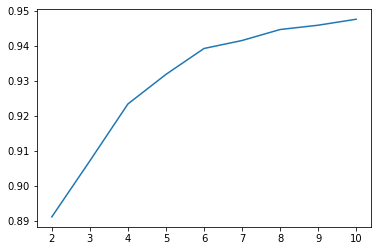

In [20]:
corr_all = [np.mean(r_all_2), np.mean(r_all_3), np.mean(r_all_4), 
           np.mean(r_all_5), np.mean(r_all_6), np.mean(r_all_7),
           np.mean(r_all_8), np.mean(r_all_9), np.mean(r_all_10)]
plt.plot(corr_all)
plt.xticks(np.arange(9), np.arange(2, 11))
plt.show()

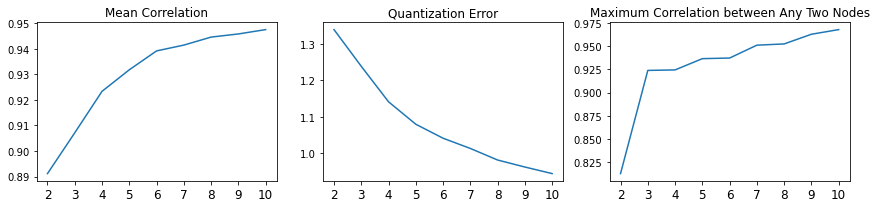

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axes[0].plot(corr_all)
axes[0].set_title('Mean Correlation', fontsize=12)
axes[1].plot(dis_all)
axes[1].set_title('Quantization Error', fontsize=12)
axes[2].plot(cc_all)
axes[2].set_title('Maximum Correlation between Any Two Nodes', fontsize=12)
for ax in axes:
    ax.set_xticks(np.arange(9))
    ax.set_xticklabels(np.arange(2, 11), fontsize=12)
plt.tight_layout()
plt.savefig('metrics.png', dpi=120, bbox_inches='tight')
plt.show()